# Ch6. 신용 위험 추정

(\*) 신용 위험 관리의 목표: 신용 위험 노출을 허용 가능한 한도 내에서 유지 ~ 음행의 위험 조정 수익률 최대화
- 신용 위험 추정 어려움 -> 규제 기관인 바젤: 은행 자본 요건 강화 위한 규정 설정함
- 은행에 대한 강력한 자본 요건 요구: 은행이 격동의 시기에 자본 완충 장치를 갖춰야 한다는 생각에 기인함
- 금융기관들: 서로 담보 제공 빈번 -> 이들 사이에 연쇄적인 채무불이행 일어나면 -> 금융 시장이 붕괴될 수 있음 => 금융 시스템 안정성 위해 최소한의 자본금 갖춰야 함
- 최소 자본: 대출 불가 -> 이익 낼 수 없는 자산


(\*) 신용 위험 추정
채무불이행 가능성 이외에도 신용 위험에 세 가지 정의상 특성이 있음:
- 노출: 채무불이행 or 채무이행 능력에 불리한 변화를 겪을 수 있는 당사자
- 우도: 당사자가 의무를 불이행할 가능성
- 회수율: 채무불이행이 발생하는 경우 회수할 수 있는 양
$\\$예상 손실 = EAD(채무 불이행시 노출) X LGD(0 ~ 1 채무 불이행 시 예상 손실) X PD(채무불이행 확률)

(\*) 위험 버켓팅
$\\$: 신용도가 유사한 차용인들끼리 그룹화
$\\$In K-means: 클러스터 내 관측값의 거리는 클러스터 중심을 기반으로 계산됨 ~ 거리에 따라 관측치가 군집화됨
- 거리 측정 방식: 유클리드 / 민코프스키 / 맨해튼
- 군집화의 목적: 중심과 관측치 사이의 거리 최소화 -> 유사한 관측치들이 동일한 클러스터에 있도록 함
- 중심과 관측값 사이의 제곱 오차의 합 최소화: $\sum^K_{i=1}\sum_{X\inC_i}(C_i-x)^2$
- K-means: 닫힌 해 없음 -> 근사해 -> By 기대 최대화(EM) 알고리듬
1. 중심이 될 k개의 임의의 점
2. 거리 측정법 기반 -> 관측치와 n개의 중심 사이의 거리 계산 -> 거리 기반으로 각 관측치를 가장 가까운 클러스터에 할당
3. 할당을 기반으로 클러스터 센터 갱신
4. 중심이 변경되지 않을 때까지 2단계부터 절차 반복
- 최적의 클러스터 수: 
$\\$(i) by 엘보우 방법(가장 가까운 중심까지의 거리 제곱의 합)
$\\$(ii) by 실루엣 점수([-1,+1]): $\frac{x-y}{max(x,y)}$ ~ x: 클러스터 간의 평균 거리, y: 동일 클러스터 내의 모든 점들끼리의 평균 거리
$\\$(iii) by 칼린스키-하라바츠: $\frac{SS_B}{SS_W}\times\frac{N-k}{k-1}$ ~ $SS_B$: 클러스터 간 분산, $SS_W$: 클러스터 내 분산
$\\$(iv) by 갭 분석: 
- $d_{ii^e}$를 $x_{ij}$와 $x_{i^ej}$ 사이 유클리드 거리
- $C_r$: 클러스터 r의 관측치 수
- 클러스터 r의 모든 관측치에 대한 쌍별 거리의 합: $D_r=\sum_{i,i^e\inC_r}d_{i,i^e}$
- 클러스터 내 제곱합: $W_k=\sum^k_{r=1}\frac{1}{2_{n_r}}D_r$
- $W_k$의 기댓갑: $\log(pn/12)-(2/p)\log(k)+\text{상수}$

In [1]:
import pandas as pd
credit=pd.read_csv('credit_data_risk.csv')
del credit['Unnamed: 0']

In [ ]:
credit.describe()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize']=(10,6)

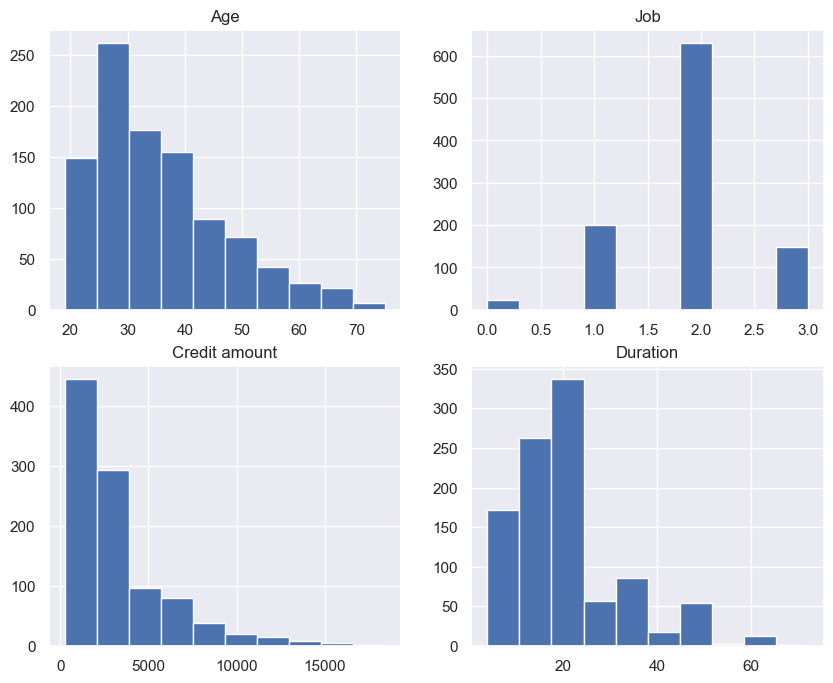

In [3]:
numerical_credit=credit.select_dtypes(exclude='O') # 모든 숫자 변수 얻기 위해 객체 유형 변수 삭제
plt.figure(figsize=(10,8))
k=0
cols=numerical_credit.columns
for i,j in zip(range(len(cols)), cols):
    k+=1
    plt.subplot(2,2,k)
    plt.hist(numerical_credit.iloc[:,i])
    plt.title(j)

In [4]:
# 1. 엘보우 방법: 최적의 클러스터 수 -> 곡선의 기울기 관찰 -> 곡선의 기울기가 더 낮아지는 컷오프 지점 결정
# 평평해질수록 클러스터 내의 포인트가 얼마나 멀리 떨어져 있는지 알려주는 관성이 감소함
# 클러스터 수 증가해 분석이 더 복잡해지면, 그 절충점 감안 ~ 중단 기준: 곡선이 더 평평해지는 지점
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

scaler=StandardScaler()
scaled_credit=scaler.fit_transform(numerical_credit) # 표준 정규분포처럼(Z 변환) 변환

In [5]:
distance=[]
for k in range(1,10):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(scaled_credit) 
    distance.append(kmeans.inertia_) #관성: 가장 가까운 중심까지의 거리 제곱의 합으로 계산

Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\82103\anaconda3\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\Users\82103\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\82103\anaconda3\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\82103\anaconda3\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "<frozen codecs>", line 325, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 4: invalid start byte


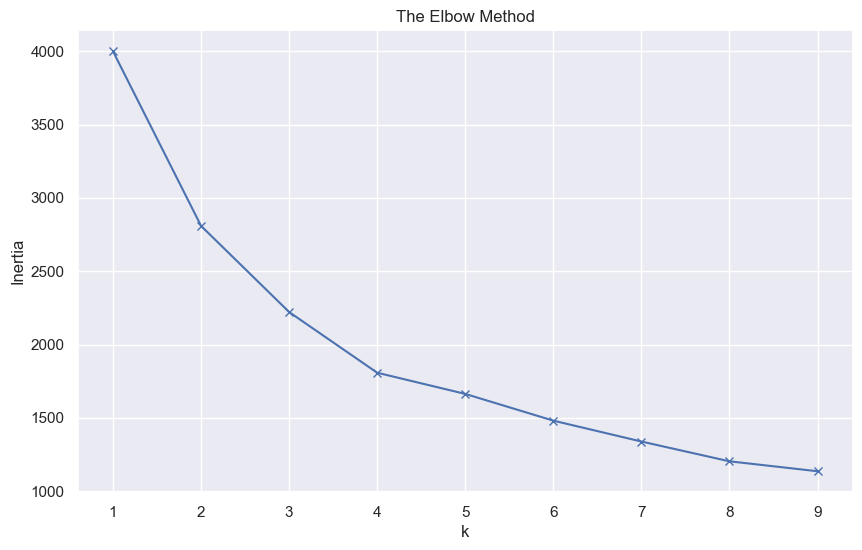

In [6]:
plt.plot(range(1,10), distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

In [ ]:
!pip install yellowbrick

In [7]:
# 클러스터 2~10까지 x축에 실루엣 점수 표시
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

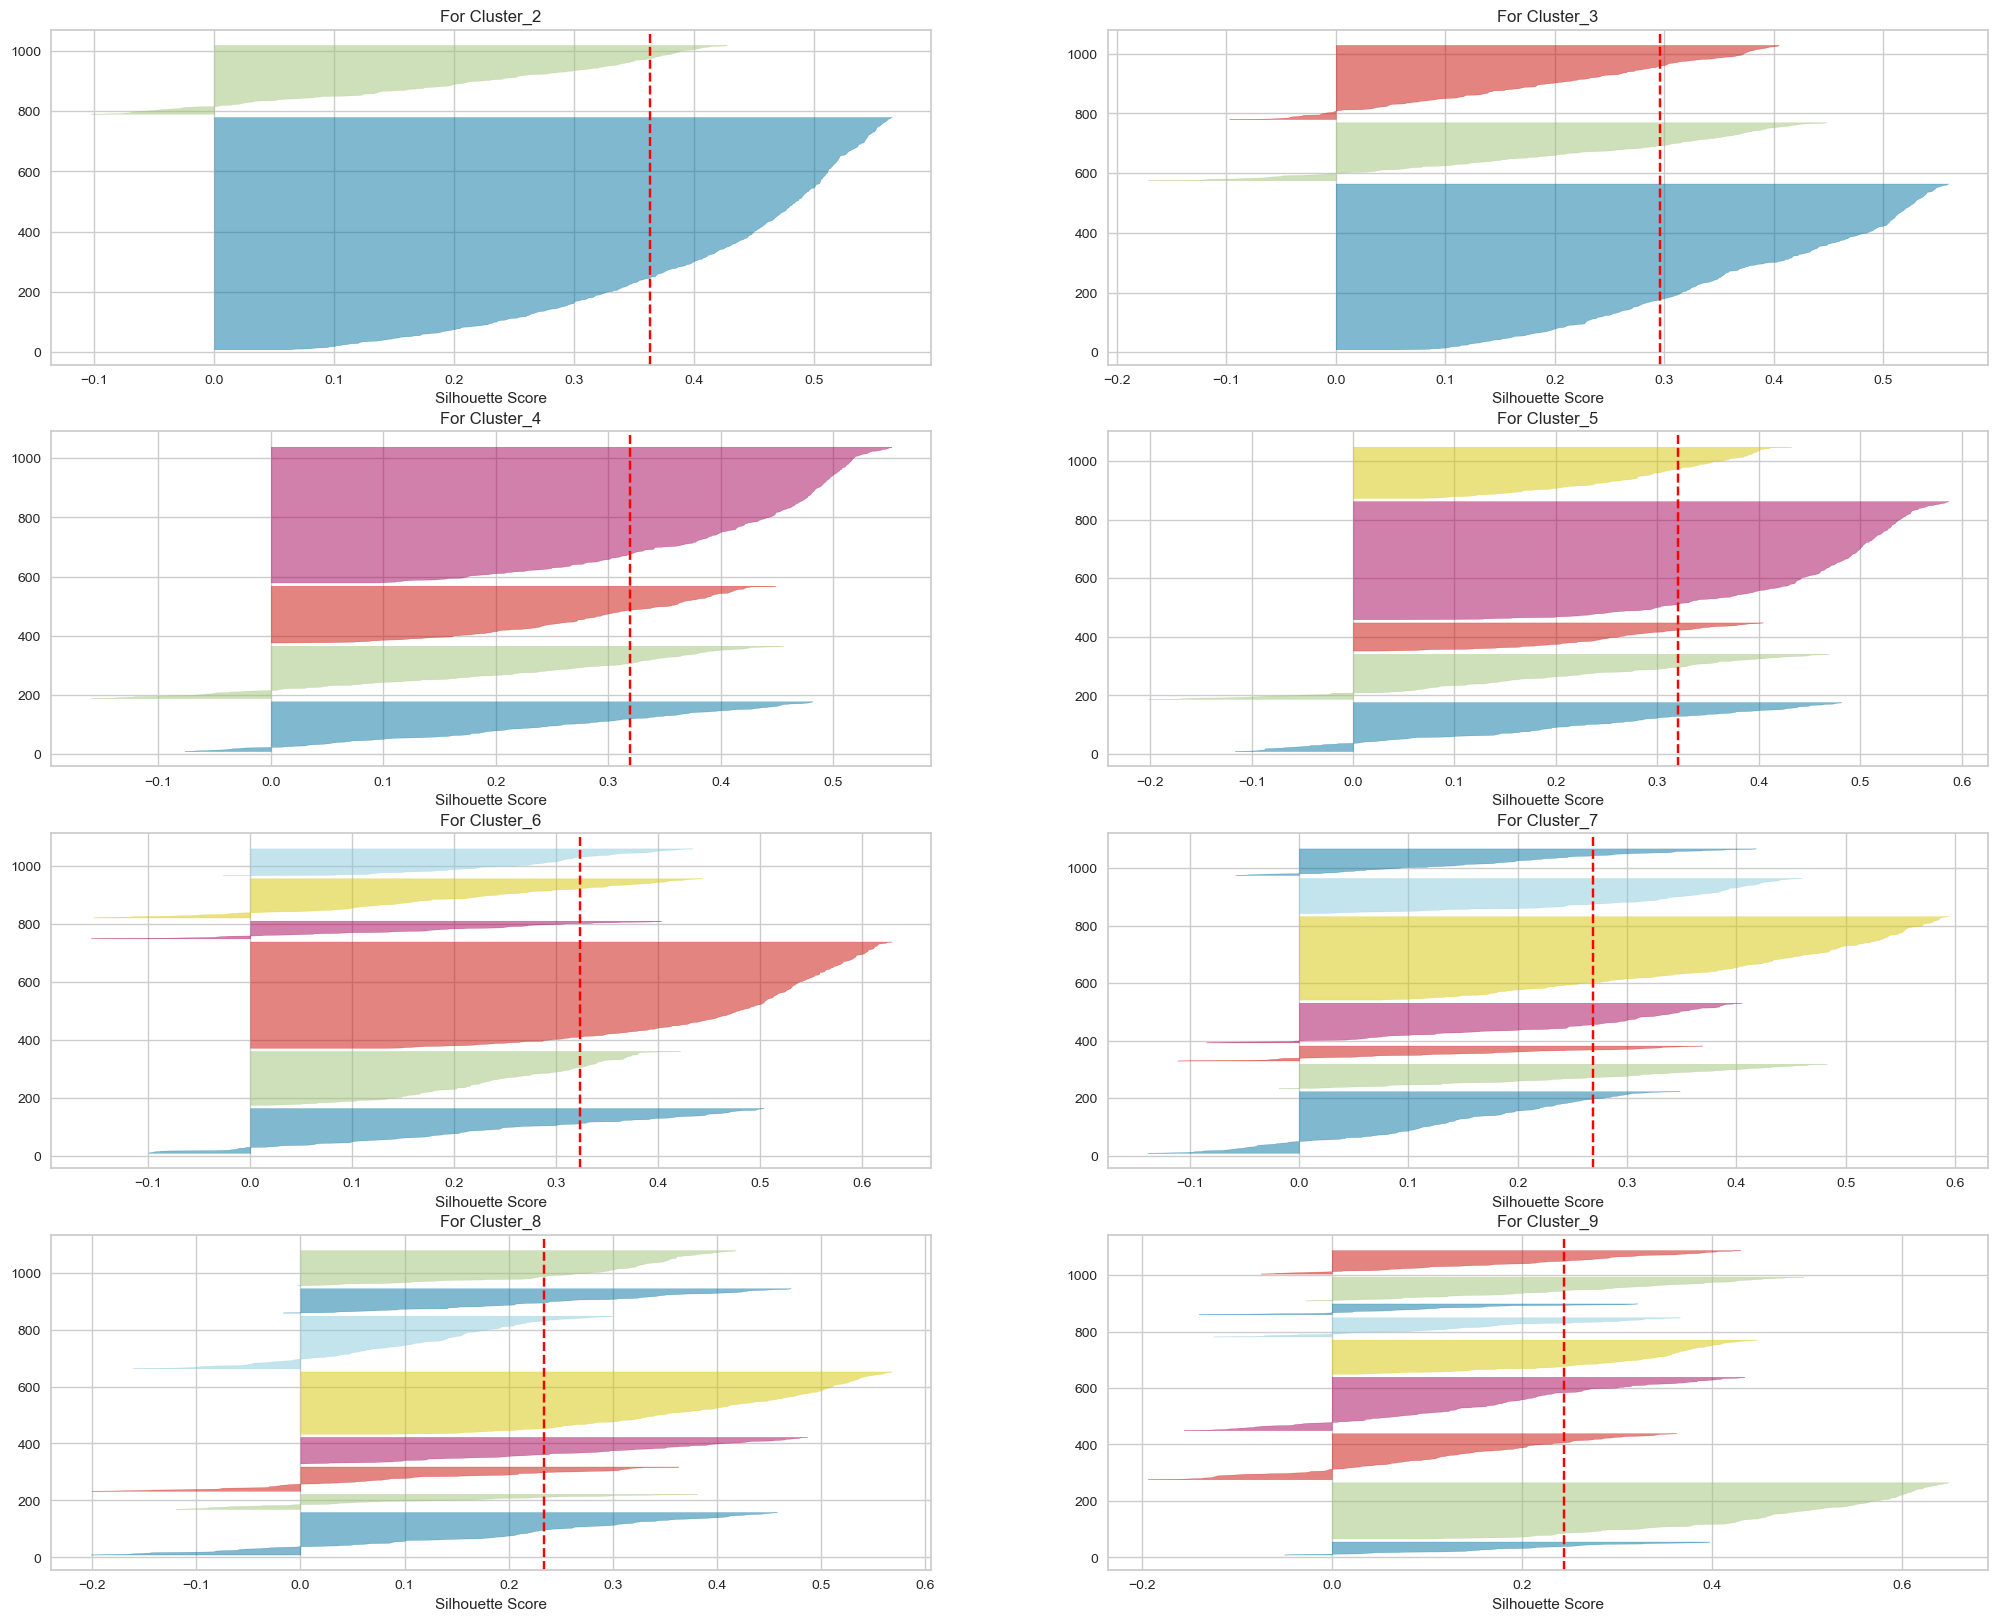

In [8]:
fig, ax=plt.subplots(4,2,figsize=(25,20))
for i in range(2,10):
    km=KMeans(n_clusters=i)
    q,r=divmod(i,2) # 몫과 나머지
    visualizer=SilhouetteVisualizer(km, colors='yellowbrick',ax=ax[q-1][r])
    visualizer.fit(scaled_credit)
    ax[q-1][r].set_title("For Cluster_"+str(i))
    ax[q-1][r].set_xlabel('Silhouette Score')

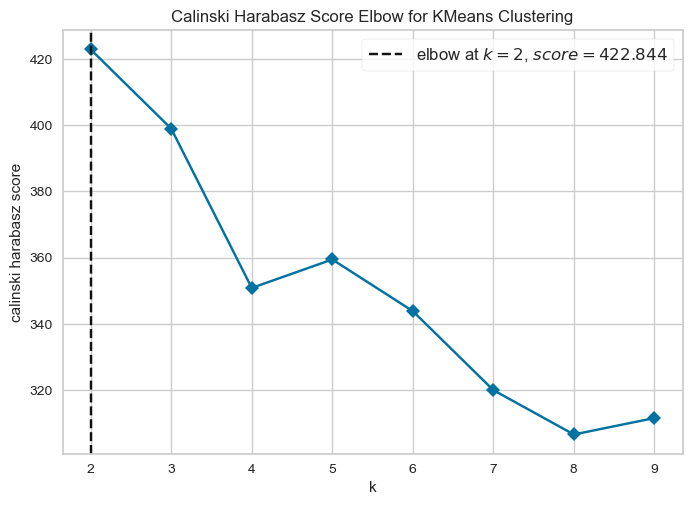

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [9]:
# 3. 가잔 높은 CH 찾기
from yellowbrick.cluster import KElbowVisualizer
model=KMeans()
visualizer=KElbowVisualizer(model, k=(2,10), metric='calinski_harabasz',timings=False)
visualizer.fit(scaled_credit)
visualizer.show()

=> 두 클러스터에서 중단하는 것이 최적의 결정임

In [ ]:
'''
# 4. 갭 분석
from gap_statistic.optimalK import OptimalK
optimalK=OptimalK(n_jobs=8, parallel_backend='joblib') # 최적의 K 계산해줌
# CPU 8개, 병렬 처리
# k를 1~9개까지 하나씩 시도
n_clusters=optimalK(scaled_credit, cluster_array=np.arange(1,10)) # 갭 통계 기반으로 클러스터 수 식별
gap_result=optimalK.gap_df

plt.plot(gap_result.n_clusters, gap_result.gap_value)
min_ylim, max_ylim=plt.ylim()
plt.axhline(np.max(gap_result.gap_value), color='r', linestyle='dashed', linewidth=2)
plt.title('Gap Analysis')
plt.xlabel('Number of Cluster')
plt.ylabel('Gap Value')
plt.show()
'''

In [10]:
kmeans=KMeans(n_clusters=2)
clusters=kmeans.fit_predict(scaled_credit)

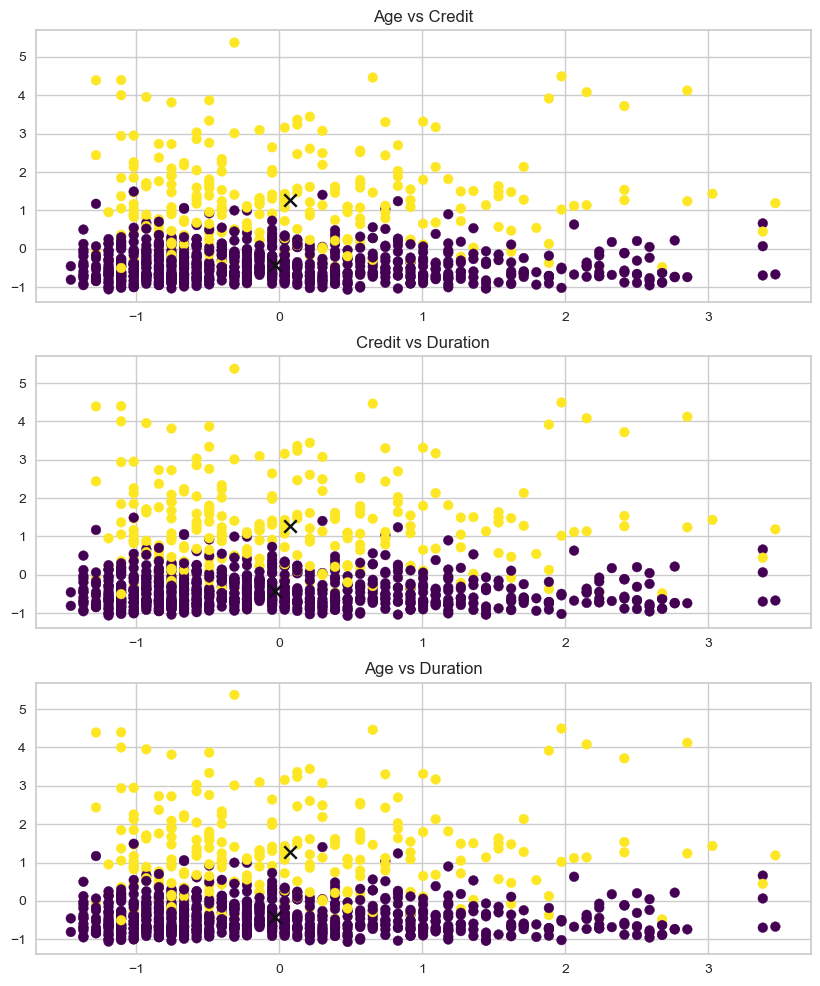

In [11]:
plt.figure(figsize=(10,12))
plt.subplot(311)
plt.scatter(scaled_credit[:,0], scaled_credit[:,2], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,2],s=80,marker='x',color='k')
plt.title('Age vs Credit')
plt.subplot(312)
plt.scatter(scaled_credit[:,0], scaled_credit[:,2], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,2],s=80,marker='x',color='k')
plt.title('Credit vs Duration')
plt.subplot(313)
plt.scatter(scaled_credit[:,0], scaled_credit[:,2], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,2],s=80,marker='x',color='k')
plt.title('Age vs Duration')
plt.show()

(\*) 로지스틱 회귀를 사용한 채무불이행 추정
- 클러스터 -> 유사한 특성을 가진 고객을 동일한 방식으로 취급 가능
1. 로지스틱 회귀: 금융 산업에 널리 적용할 수 있는 분류 알고리듬
- 일부 독립변수에 기반해 이산 출력을 예측함
- 조건부 확률: $Pr(Y=1|X=x)$
- 로지스틱 회귀 모델: $\log(frac{p}{1-p})=\beta_0+\beta_1x$
- $p=\frac{e^{\beta_0+\beta_1x}}{1+e^{\beta_0+\beta_1x}}$

In [12]:
clusters, counts=np.unique(kmeans.labels_, return_counts=True)

In [13]:
cluster_dict={}
for i in range(len(clusters)):
    cluster_dict[i]=scaled_credit[np.where(kmeans.labels_==i)] # 추출

In [14]:
credit['clusters']=pd.DataFrame(kmeans.labels_)
df_scaled=pd.DataFrame(scaled_credit)
df_scaled['clusters']=credit['clusters']

In [15]:
df_scaled['Risk']=credit['Risk']
df_scaled.columns=['Age','Job','Credit amount','Duration','Clusters','Risk']
df_scaled[df_scaled.Clusters==0]['Risk'].value_counts()

Risk
good    561
bad     190
Name: count, dtype: int64

In [16]:
df_scaled[df_scaled.Clusters==1]['Risk'].value_counts()

Risk
good    139
bad     110
Name: count, dtype: int64

<Axes: title={'center': 'Frequency of Risk Level'}, xlabel='Risk'>

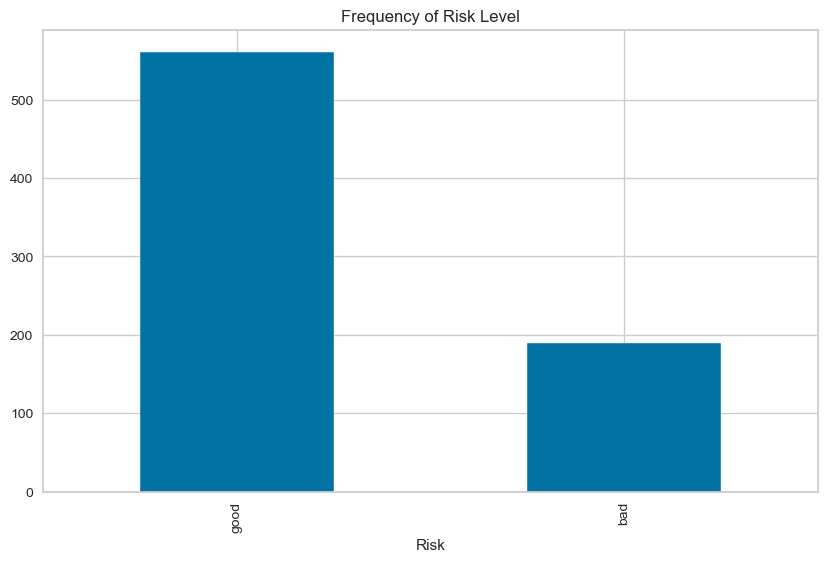

In [17]:
df_scaled[df_scaled.Clusters==0]['Risk'].value_counts().plot(kind='bar',figsize=(10,6),title='Frequency of Risk Level')

<Axes: title={'center': 'Frequency of Risk Level'}, xlabel='Risk'>

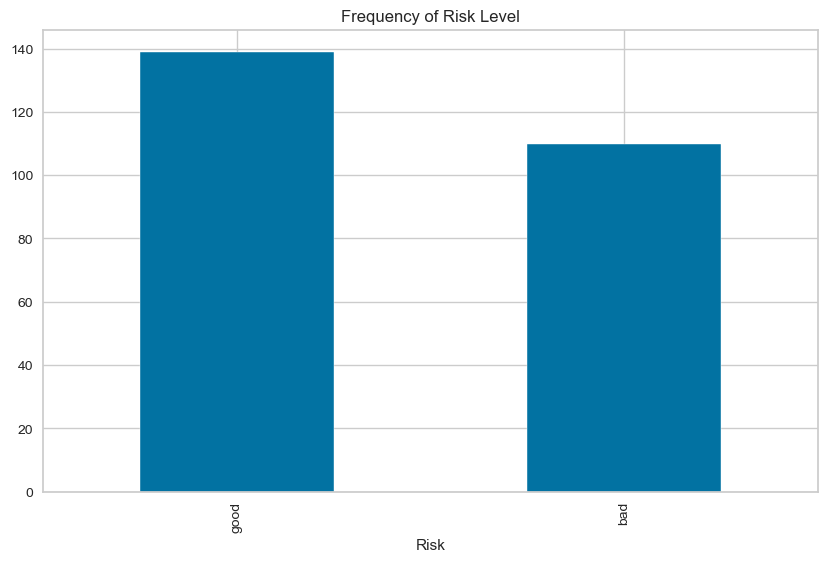

In [18]:
df_scaled[df_scaled.Clusters==1]['Risk'].value_counts().plot(kind='bar',figsize=(10,6),title='Frequency of Risk Level')

=> 2nd 클러스터: 1st 클러스터에 비해 양호/불량 위험 수준의 빈도가 더 균형을 이룸
- 부류 불균형: 한 부류가 다른 부류보다 월등히 많을 때 발생
- SMOTE & ENN 조합 -> 불균형 데이터를 균형 데이터로 변환함 ~ but 첫 번째에서 얻은 데이터에만 적용함

In [19]:
from sklearn.model_selection import train_test_split
df_scaled['Risk']=df_scaled['Risk'].replace({'good':1, 'bad':0})
X=df_scaled.drop('Risk', axis=1)
y=df_scaled.loc[:,['Risk','Clusters']]

C:\Users\82103\AppData\Local\Temp\ipykernel_22964\3572564229.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_scaled['Risk']=df_scaled['Risk'].replace({'good':1, 'bad':0})


In [20]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)
# 마지막 열 삭제
first_cluster_train=X_train[X_train.Clusters==0].iloc[:,:-1]
second_cluster_train=X_train[X_train.Clusters==1].iloc[:,:-1]

In [21]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

In [22]:
X_train1=first_cluster_train
y_train1=y_train[y_train.Clusters==0]['Risk']
smote=SMOTEENN(random_state=2)
# 불균형 -> 균형 데이터로 전환
X_train1, y_train1=smote.fit_resample(X_train1, y_train1.ravel()) # Numpy, Pandas에서 1차원 배열로 펴주는 함수
logit=sm.Logit(y_train1, X_train1)
logit_fit1=logit.fit()
print(logit_fit1.summary())

Optimization terminated successfully.
         Current function value: 0.435469
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  389
Model:                          Logit   Df Residuals:                      385
Method:                           MLE   Df Model:                            3
Date:                    화, 20 1 2026   Pseudo R-squ.:                  0.3632
Time:                        13:12:57   Log-Likelihood:                -169.40
converged:                       True   LL-Null:                       -266.01
Covariance Type:            nonrobust   LLR p-value:                 1.224e-41
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               1.5828      0.179      8.834      0.000       1.232       1.934
Job               0.

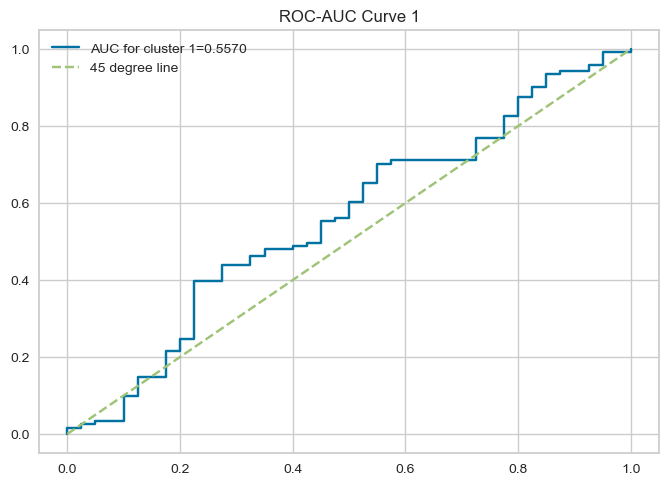

In [23]:
# 클러스터를 기반으로 서로 다른 데이터셋을 생성해 예측 분석을 수행함
first_cluster_test=X_test[X_test.Clusters==0].iloc[:,:-1]
second_cluster_test=X_test[X_test.Clusters==1].iloc[:,:-1]

X_test1=first_cluster_test
y_test1=y_test[y_test.Clusters==0]['Risk']
pred_prob1=logit_fit1.predict(X_test1)

false_pos, true_pos, _=roc_curve(y_test1.values, pred_prob1)
auc=roc_auc_score(y_test1, pred_prob1)
plt.plot(false_pos, true_pos, label='AUC for cluster 1={:.4f}'.format(auc))
plt.plot([0,1],[0,1],linestyle='--',label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve 1')
plt.show()

In [ ]:
!pip install pymc

In [ ]:
# 최대 사후 확률(MAP) ~ 베이즈 추정 & 마르코프 체인 몬테 카를로(MCMC) 접근 방식
# 베이즈 분석
import pymc as pm
import arviz as az

with pm.Model() as logistic_model1: # 베이즈 모델을 logistic_model1으로 식별
    # 데이터를 보기 전 내 생각
    beta_age=pm.Normal('coeff_age',mu=0,sigma=10)
    beta_job=pm.Normal('coeff_job',mu=0,sigma=10)
    beta_credit=pm.Normal('coeff_credit_amount',mu=0,sigma=10)
    beta_dur=pm.Normal('coeff_duration',mu=0,sigma=10)
    # p: 선형회귀의 결과값을 확률 0-1로 변환
    p=pm.Deterministic('p',pm.math.sigmoid(beta_age*X_train1['Age']
                                           +beta_job*X_train1['Job']
                                           +beta_credit*X_train1['Credit amount']
                                           +beta_dur*X_train1['Duration']))
with logistic_model1:
    # 이 모델에 맞추기 위해 beta들을 수정함
    observed=pm.Bernoulli("risk",p,observed=y_train1)
    # 최대 사후확률 추정
    map_estimate=pm.find_MAP()


In [ ]:
param_list=['coeff_age','coeff_job','coeff_credit_amount','coeff_duration']
params={}
for i in param_list:
    params[i]=[np.round(map_estimate[i],6)]
bayesian_params=pd.DataFrame.from_dict(params)
print('The result of Bayesian estimation:\n {}'.format(bayesian_params))

(\*) 얻기 어려운 지역 최댓값을 찾는 대신 샘플링 절차를 기반으로 대략적인 기대치를 찾음 ~ "MCMC"
- Monte Carlo: 무작위로 점을 많이 찍어서(샘플링) 전체적인 값 추정
- Markov Chain: 점을 아무 데나 x, 지금 있는 위치에서 다음 위치로 한 발자국씩 이동
-$\\$(\*) 가장 잘 알려진 방법 중 하나: 메트로폴리스-헤이스팅스(MH) 알고리듬 ~ 다음 발자국을 어디로 옮길지 결정하는 구체적인 규칙

In [ ]:
# MH 알고리듬을 기반으로 베이즈 추정 적용
import logging # 경고 메시지 표시 x
logger=logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

with logistic_model1:
    step=pm.Metropolis()
    trace=pm.sample(10000, step=step, progressbar=False) #10,000개의 샘플로 모델 실행
az.plot_trace(trace) # 사후 도면 만들기
plt.show()

with logistic_model1:
    display(az.summary(trace, round_to=6)[:4])

(\*) 서포트 벡터 머신을 사용한 채무불이행 추정 확률
- SVM: 모수적 모델, 고차원 데이터와 잘 작동함
- HalvingRandomSearchCV: 초매개변수 조정 접근 방식 ~ 반복 선택을 통해 작동 -> 더 적은 자원 사용 -> 성능 향상되며 시간 절약
$\\$-> 후보 매개변수를 식별하기 위해 연속적인 반감기를 사용해 최적의 매개변수를 찾으려 함
1. 첫 반복에서 훈련 샘플 중 특정 수를 활용해 모든 매개변수 조합을 평가함
2. 두 번째 반복에서는 선택한 매개변수 중 일부를 사용해 대량의 훈련 샘플에 적용
3. 마지막 반복까지 가며 모델에 최고 득점 후보만 포함시킴

In [27]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv # 연속 반감 검색 활성화 위한 라이브러리
from sklearn.model_selection import HalvingRandomSearchCV # 반감기 검색 실행 위한 라이브러리
import time

In [ ]:
# 후보 리스트(Hyperparameter)
param_svc={'gamma':[1e-6,1e-2], # 데이터 포인트 거리 ~ 영향력
           'C': [0.001,.09,1,5,10], # 오류 얼마나 봐줄지
           'kernel':('linear','rbf')} # 데이터를 자르는 모양

In [ ]:
svc=SVC(class_weight='balanced') # 소수 데이터 틀렸을 때 벌점 크게 줌
# roc_auc: 내가 위험하다고 찍은 사람이 진짜 위험한 사람일 확률
halve_SVC=HalvingRandomSearchCV(svc, param_svc, scoring='roc_auc',n_jobs=-1) # 병렬 처리 사용해 반감기 검색 실행
halve_SVC.fit(X_train1, y_train1)

,estimator,SVC(class_weight='balanced')
,param_distributions,"{'C': [0.001, 0.09, ...], 'gamma': [1e-06, 0.01], 'kernel': ('linear', ...)}"
,n_candidates,'exhaust'
,factor,3
,resource,'n_samples'
,max_resources,'auto'
,min_resources,'smallest'
,aggressive_elimination,False
,cv,5
,scoring,'roc_auc'
,refit,True


In [30]:
print('Best hyperparameters for first cluster in SVC {} with {}'.format(halve_SVC.best_score_, halve_SVC.best_params_))

Best hyperparameters for first cluster in SVC 0.8751015207518413 with {'kernel': 'linear', 'gamma': 1e-06, 'C': 1}


In [31]:
y_pred_SVC1=halve_SVC.predict(X_test1)
print('The ROC AUC score of SVC for first cluster is {:.4f}'.format(roc_auc_score(y_test1, y_pred_SVC1)))

The ROC AUC score of SVC for first cluster is 0.5272


- 더 높은 C값: 더 나은 분류를 위해 더 작은 Margin을 선택해야 함
- gamma: 더 낮을수록 결정에 대한 서포트 벡터의 영향이 커짐

(\*) 랜덤 포레스트를 사용한 채무불이행 추정 확률
- 랜덤 포레스트 장점: 다수의 샘플이 있을 때 우수한 예츣 성능

In [32]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

In [33]:
param_rfc={'n_estimators':[100,300],
           'criterion':['gini','entropy'],
           'max_features':['auto','sqrt','log2'],
           'max_depth':[3,4,5,6],
           'min_samples_split':[5,10]}

In [34]:
halve_RF=HalvingRandomSearchCV(rfc, param_rfc, scoring='roc_auc', n_jobs=1)
halve_RF.fit(X_train1, y_train1)
print('Best hyperparameters for first cluster in RF {} with {}'.format(halve_RF.best_score_, halve_RF.best_params_))

Best hyperparameters for first cluster in RF 0.9148676323676324 with {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy'}


In [35]:
y_pred_RF1=halve_RF.predict(X_test1)
print('The ROC AUC score of RF for first cluster is {:.4f}'.format(roc_auc_score(y_test1,y_pred_RF1)))

The ROC AUC score of RF for first cluster is 0.5477


(\*) 데이터 차원이 낮고 관측값이 많을 때 랜덤 포레스트 좋음

(\*) 신경망을 사용한 채무불이행 추정 확률
- 데이터의 숨겨진 구조 알아내는 것: 어려움 
- 신경망 모델 설정 시 GridSearchCV 사용해 은닉층의 수, 최적화 기법 및 학습률 최적화함

In [37]:
from sklearn.neural_network import MLPClassifier
param_NN={'hidden_layer_sizes':[(100,50),(50,50),(10,100)],
          'solver':['lbfgs','sgd','adam'],
          'learning_rate_init':[0.001,0.05]}
MLP=MLPClassifier(random_state=42)
param_halve_NN=HalvingRandomSearchCV(MLP, param_NN,scoring='roc_auc')
param_halve_NN.fit(X_train1, y_train1)

print('Best hyperparameters for first cluster in NN are {}'.format(param_halve_NN.best_params_))

y_pred_NN1=param_halve_NN.predict(X_test1)
print('The ROC AUC score of NN for first cluster is {:.4f}'.format(roc_auc_score(y_test1, y_pred_NN1)))

Best hyperparameters for first cluster in NN are {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 50)}
The ROC AUC score of NN for first cluster is 0.5477


(\*) 딥러닝을 사용한 채무불이행 추정 확률
- 초매개변수: 배치 크기, 에폭 및 드롭아웃 비율

In [39]:
!pip install scikeras

In [40]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [42]:
def DL_risk(dropout_rate, verbose=0):
    model=keras.Sequential()
    model.add(Dense(128, kernel_initializer='normal', activation='relu', input_dim=4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu'))
    model.add(Dense(8,kernel_initializer='normal',activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='rmsprop')
    return model

In [ ]:
parameters={'batch_size': [10,50,100],
            'epochs':[50,100,150],
            'dropout_rate':[0.2, 0.4]}
model=KerasClassifier(model=DL_risk, dropout_rate=0.2, verbose=0)
gs=GridSearchCV(estimator=model, param_grid=parameters, scoring='roc_auc')

gs.fit(X_train1, y_train1, verbose=0)
print('Best hyperparameters for first cluster in DL are {}'.format(gs.best_params_))

In [ ]:
model=KerasClassifier(build_fn=DL_risk,
                      dropout_rate=gs.best_params_['dropout_rate'],
                      verbose=0,
                      batch_size=gs.best_params_['batch_size'],
                      epochs=gs.best_params_['epochs'])
model.fit(X_train1, y_train1)
DL_predict1=model.predict(X_test1)
DL_ROC_AUC=roc_auc_score(y_test1, pd.DataFrame(DL_predict1.flatten()))
print('DL_ROC_AUC is {:.4f}'.format(DL_ROC_AUC))

(\*) 업계에서는 네트워크 구조의 불투명한 특성으로 인해 기존 모델과 함께 사용하는 것이 좋음